In [23]:
import requests
import time # import for playing nice and not getting blocked
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup

In [24]:
url = "https://www.ss.com/lv/transport/cars/volkswagen/sell/"
req = requests.get(url)

In [25]:
soup = BeautifulSoup(req.text, 'lxml')
headline = soup.find("tr", {"id":"head_line"})

In [26]:
headtds = headline.find_all("td")
headcolumns = [el.text for el in headtds[1:]]

In [27]:
def getColList(soup):
    column_list = ["description","url"] # we decided to that we need these two column names no matter the html
    headline = soup.find("tr", {"id":"head_line"})
    headtds = headline.find_all("td")
    headcolumns = [el.text for el in headtds[1:]] # this will get all column names starting with 2nd in HTML
    column_list += headcolumns
    return column_list

In [28]:
column_names = getColList(soup)

In [29]:
def getRowList(soup):
    trows = soup.find_all('tr')
    aprows = [row for row in trows if row.get('id',"").startswith("tr_") and not row.get('id',"").startswith("tr_bnr") ]
    return aprows

In [30]:
def getRow(row,colist=column_names):
    row_tds = row.find_all('td')
    rowDict = {}
    if len(row_tds) < 3: # a little sanity check
        print("Hmm bad row")
        return rowDict
    
    rowDict[colist[0]] = row_tds[2].text # so the big assumption is that we always get description in 3rd column
    rowDict[colist[1]] = "https://ss.com" + row_tds[1].find('a').get('href')
    for td,key in zip(row_tds[3:],colist[2:]): 
        rowDict[key] = td.text
    return rowDict

In [31]:
def getRows(rowlist,colist=column_names):
    return [getRow(row, colist=colist) for row in rowlist]

In [32]:
def getDFfromURL(url):
    # print("getting data from", url)
    req = requests.get(url)
    if req.status_code != 200:
        print("Request Fail with", req.status_code)
        return None # maybe return empty dataframe here
    soup = BeautifulSoup(req.text, 'lxml')
    column_names = getColList(soup)
    rowlist = getRowList(soup)
    rows = getRows(rowlist,colist=column_names)
    return pd.DataFrame(rows, columns=column_names)

In [33]:
vw_auto = getDFfromURL(url)
vw_auto.head()

,description,url,Modelis,Gads,Tilp.,Nobrauk.,Cena
0,"1.9 Tdi, 96Kw/130Zs, multistūre, lietus sensor...",https://ss.com/msg/lv/transport/cars/volkswage...,Passat (B5),2004,1.9D,302 tūkst.,"1,500 €"
1,"Машина в хорошем состоянии, возможен вариант о...",https://ss.com/msg/lv/transport/cars/volkswage...,Golf 5,2007,1.9D,-,"2,860 €"
2,"Pārdodu/mainu brīnišķīgu, ģimenes, septiņvietī...",https://ss.com/msg/lv/transport/cars/volkswage...,Touran,2014,1.4,239 tūkst.,"4,799 €"
3,Īpašnieks pārdod auto lieliskā tehniskā stāvok...,https://ss.com/msg/lv/transport/cars/volkswage...,Touareg,2013,3.0D,-,"14,900 €"
4,Jaunā TA. Nodoklis nomaksāts. Ļoti ekanomisk. ...,https://ss.com/msg/lv/transport/cars/volkswage...,Golf 4,1999,1.9D,413 tūkst.,850 €


In [34]:
def getAllLocalUrls(url):
    """Get a list of all urls including paginated pages"""
    results = [url] # default is just the url if no extra pages found
    req = requests.get(url)
    if req.status_code != 200:
        print(f"Bad response! {req.status_code}")
        return []
    soup = BeautifulSoup(req.text, 'lxml')
    # we just need a one element
    prevanchor = soup.find('a', {"rel":"prev"}) # find finds first match only
    if prevanchor == None: # means there is only one page of ads
        return results # we return a list with just the original url
    href = prevanchor.attrs.get('href')
    lastPageNum = int(href.split('/page')[-1].split('.html')[0])
    print("Last page is",lastPageNum)
    # then we use list comprehension to create a list of urls
    nurls = [f"{url}page{n}.html" for n in range(2,lastPageNum+1)]
    results += nurls
    return results

In [35]:
all_vw_pages = getAllLocalUrls(url)

Last page is 84


In [36]:
def get_all_ads_df(start_url, save_excel_path=None, save_csv_path=None):
    df_list=[] # so we will save our dataframes in a list
    local_urls = getAllLocalUrls(start_url)
    for url in local_urls:
        # print(f"Gathering data from {url}")
        df_list.append(getDFfromURL(url))
        # we add a 300ms delay to avoid overloading the server
        time.sleep(0.3) # we need this to play nice! to avoid rate limit or IP ban!!
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html
    big_df = pd.concat(df_list) # then make a big dataframe from all the small dataframes
    if save_excel_path:
        big_df.to_excel(save_excel_path)
    if save_csv_path:
        big_df.to_csv(save_csv_path,encoding="utf-8")
    return big_df
    

In [70]:
all_vw = get_all_ads_df(url)
all_vw.shape

Last page is 85


(2521, 7)

In [71]:
all_vw.sample(3)

,description,url,Modelis,Gads,Tilp.,Nobrauk.,Cena
11,Pārdodu īpaši ekonomisku auto ar sešu ātrumu m...,https://ss.com/msg/lv/transport/cars/volkswage...,Touran,2008,1.9D,341 tūkst.,"3,600 €"
17,VW Amarok 2.0Tdi automats 4motion. \r\nTikko n...,https://ss.com/msg/lv/transport/cars/volkswage...,Amarok,2012,2.0D,215 tūkst.,"17,990 €"
8,"1.9 Tdi, 96Kw/130Zs, multistūre, lietus sensor...",https://ss.com/msg/lv/transport/cars/volkswage...,Passat (B5),2004,1.9D,302 tūkst.,"1,500 €"


In [58]:
all_vw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2517 entries, 0 to 26
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  2517 non-null   object
 1   url          2517 non-null   object
 2   Modelis      2517 non-null   object
 3   Gads         2517 non-null   object
 4   Tilp.        2517 non-null   object
 5   Nobrauk.     2517 non-null   object
 6   Cena         2517 non-null   object
dtypes: object(7)
memory usage: 157.3+ KB


In [72]:
all_vw['Nobrauk.'] = all_vw['Nobrauk.'].str.replace(" ","")
all_vw['Nobrauk.'] = all_vw['Nobrauk.'].str.replace("tūkst.","000")

<ipython-input-72-72f7b2be9148>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  all_vw['Nobrauk.'] = all_vw['Nobrauk.'].str.replace("tūkst.","000")


In [73]:
all_vw.sample(5)

,description,url,Modelis,Gads,Tilp.,Nobrauk.,Cena
2,Продаю фв пассат б7 в хорошем состоянии и в оч...,https://ss.com/msg/lv/transport/cars/volkswage...,Passat (B7),2012,2.0D,286000,"8,900 €"
23,"Pārdodu VW Passat 2.0d Bluemotion, Automātiska...",https://ss.com/msg/lv/transport/cars/volkswage...,Passat (B8),2015,2.0D,159000,"12,480 €"
24,"Pārdod, ļoti labā stāvoklī, ikdienā lietojusi ...",https://ss.com/msg/lv/transport/cars/volkswage...,Tiguan,2018,2.0D,38000,"21,300 €"
16,Продаётся (Или Обмен) VW Caddy Trendline 2.0 T...,https://ss.com/msg/lv/transport/cars/volkswage...,Caddy,2015,2.0D,167000,"16,550 €"
6,"VW Passat 2.0 Benzīns , 110 KW\r\nAuto iegādāt...",https://ss.com/msg/lv/transport/cars/volkswage...,Passat (B6),2007,2.0,163000,"2,730 €"


In [74]:
all_vw['Nobrauk.'] = pd.to_numeric(all_vw['Nobrauk.'], errors='coerce')

In [75]:
all_vw['Cena'] = all_vw['Cena'].str.replace("€","")
all_vw['Cena'] = all_vw['Cena'].str.replace(",","")

In [76]:
all_vw['Cena'] = pd.to_numeric(all_vw['Cena'], errors='coerce')

In [88]:
pd.options.display.float_format = '{:,.0f}'.format

In [78]:
all_vw['Tilp.'].value_counts()

2.0D    783
1.9D    534
1.6D    249
2.5D    177
1.4     168
3.0D    125
1.6      92
2.0      86
1.0      54
1.8      49
1.2      45
1.5      43
1.4D     26
2.4D     22
1.2D     11
1.3       8
5.0D      7
2.5       7
2.3       6
3.2       5
1.4H      4
3.6       3
1.8D      3
2.8       3
2.8D      2
1.7       2
4.2D      2
3.2D      1
1.1       1
E         1
1.7D      1
1.3D      1
Name: Tilp., dtype: int64

In [79]:
all_vw.isna().sum()

description      0
url              0
Modelis          0
Gads             0
Tilp.            0
Nobrauk.       453
Cena             0
dtype: int64

In [103]:
vw_grouped = all_vw.groupby(['Gads', 'Modelis']).agg(Auto_skaits=('Modelis', 'count'), Vid_Nobraukums=('Nobrauk.', 'mean'), Vid_Cena=('Cena', 'mean')).reset_index()
vw_grouped.sample(5)

,Gads,Modelis,Auto_skaits,Vid_Nobraukums,Vid_Cena
296,2011,Passat (B7),40,"266,645","7,016"
297,2011,Passat CC,3,"134,667","9,559"
135,2002,Polo,6,"282,400","1,283"
292,2011,Golf Plus,5,"214,800","6,612"
302,2011,Tiguan,4,"175,000","8,638"


In [100]:
vw_gr = all_vw.groupby('Gads').agg(Auto_skaits=('Modelis', 'count'), Vid_Nobraukums=('Nobrauk.', 'mean'), Vid_Cena=('Cena', 'mean')).reset_index()

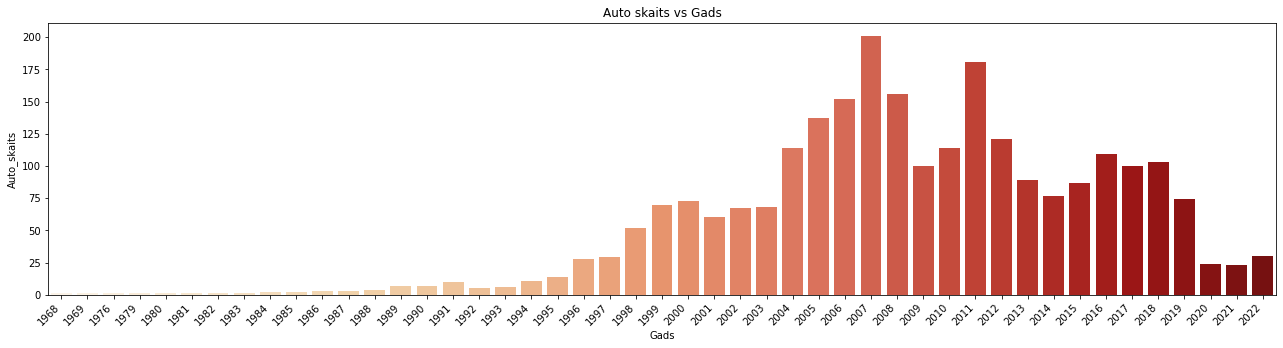

In [102]:
from matplotlib.pyplot import title


plt.figure(figsize=(22,5))
chart = sns.barplot(x='Gads', y='Auto_skaits', data = vw_gr, palette='OrRd')
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light')
chart.set(xlabel='Gads', title='Auto skaits vs Gads')

None 

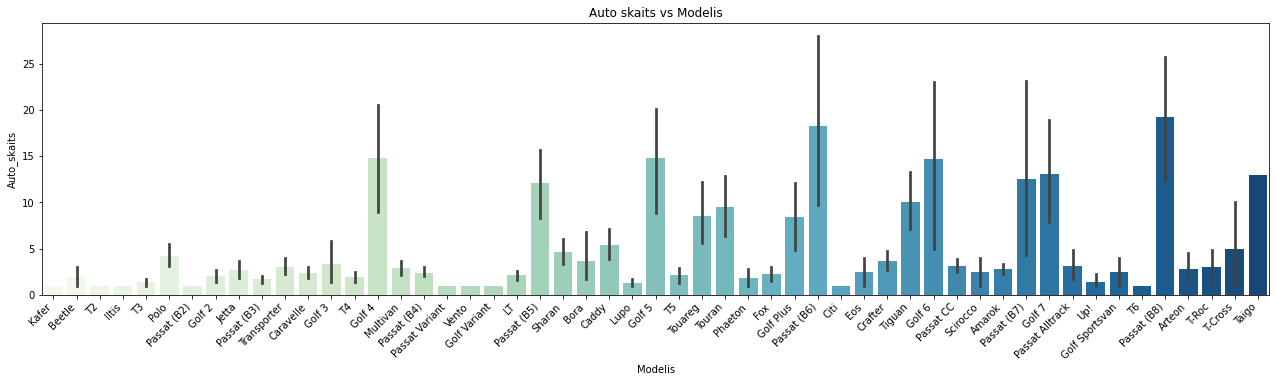

In [107]:
plt.figure(figsize=(22,5))
chart = sns.barplot(x='Modelis', y='Auto_skaits', data = vw_grouped, palette='GnBu')
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light')
chart.set(xlabel='Modelis', title='Auto skaits vs Modelis')

None

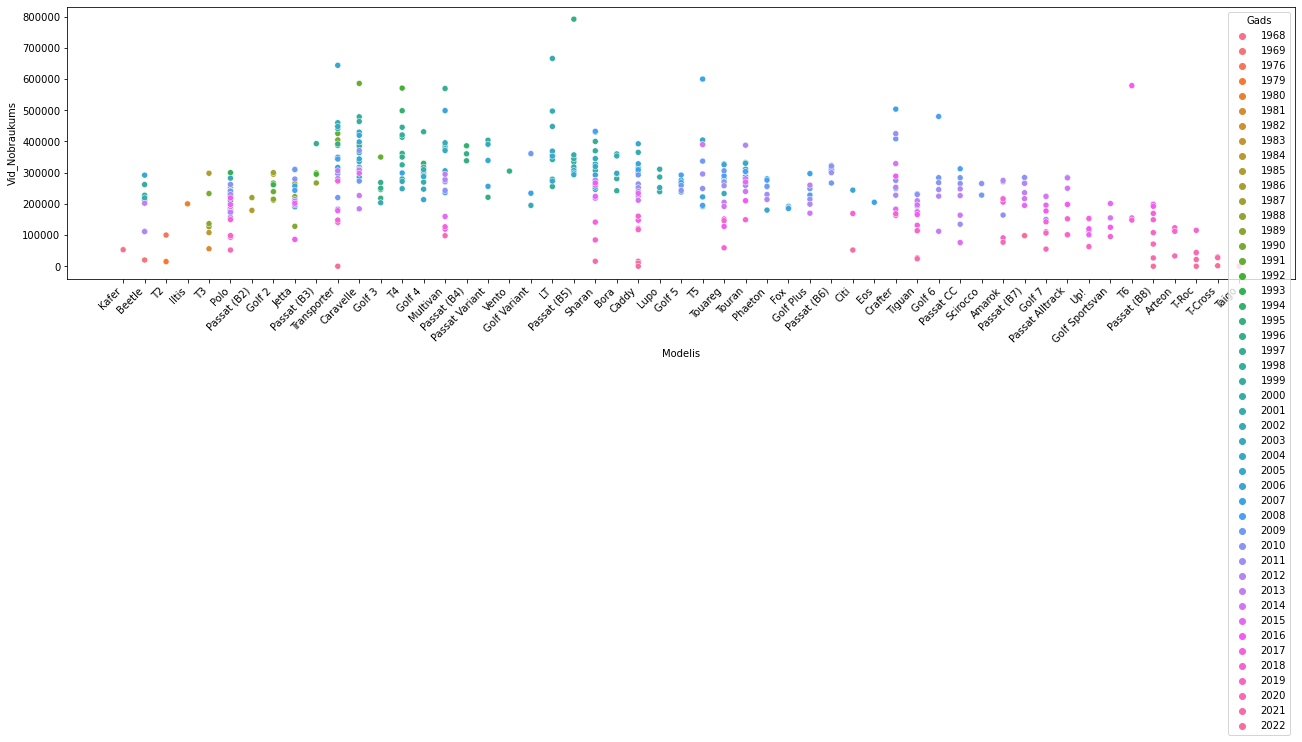

In [119]:
plt.figure(figsize=(22,5))
chart = sns.scatterplot(x='Modelis', y='Vid_Nobraukums', hue='Gads', data=vw_grouped)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light')
plt.show()